In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from statsmodels.sandbox.stats.multicomp import MultiComparison
import lacroix

from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
ablations = pd.read_csv('250531_cv_d3.csv')
ablations_embedding = ablations[ablations['split'] == 'embedding']
ablations_architecture = ablations[ablations['split'] == 'architecture']
ablations_architecture_ap = ablations_architecture.drop(range(45,60))
ablations_padding = ablations[ablations['split'] == 'padding']
best_pad = ablations_padding.groupby(by='model').mean(numeric_only=True).reset_index().sort_values("amypro22 rocauc",ascending=False)
best_emb = ablations_embedding.groupby(by='model').mean(numeric_only=True).reset_index().sort_values("amypro22 rocauc",ascending=False)
best_ab = ablations_architecture.groupby(by='model').mean(numeric_only=True).reset_index().sort_values("amypro22 rocauc",ascending=False)

ablations_architecture.head(3)

,model,mlflow,crossval_split,amypro22 rocauc,serrano158 rocauc,serrano 158 mcc,split
20,PALM,https://datalab.corp.novocorp.net/mlflow/#/exp...,1,0.6541,0.909,0.449,architecture
21,PALM,https://datalab.corp.novocorp.net/mlflow/#/exp...,2,0.6779,0.906,0.458,architecture
22,PALM,https://datalab.corp.novocorp.net/mlflow/#/exp...,3,0.6717,0.913,0.406,architecture


# new plotting fxn

In [5]:
def new_plot_simultaneous(self, comparison_name=None, ax=None, figsize=(10, 6), xlabel=None, ylabel=None, title=None, xlim=None):

        if ax is None:
            fig = plt.figure()
            ax1 = fig.add_subplot(111)
        else:
            if type(ax) == list:
                ax1=axs[ax[0], ax[1]]
            else:
                ax1=ax
        
        #if figsize is not None:
            #fig.set_size_inches(figsize)
        if getattr(self, "halfwidths", None) is None:
            self._simultaneous_ci()
        means = self._multicomp.groupstats.groupmean

        sigidx = []
        nsigidx = []
        minrange = [means[i] - self.halfwidths[i] for i in range(len(means))]
        maxrange = [means[i] + self.halfwidths[i] for i in range(len(means))]

        if comparison_name is None:
            ax1.errorbar(
                means,
                lrange(len(means)),
                xerr=self.halfwidths,
                marker="o",
                linestyle="None",
                color="k",
                ecolor="k",
            )
        else:
            if comparison_name not in self.groupsunique:
                raise ValueError("comparison_name not found in group names.")
            midx = np.where(self.groupsunique == comparison_name)[0][0]

            for i in range(len(means)):
                if self.groupsunique[i] == comparison_name:
                    continue
                if (
                    min(maxrange[i], maxrange[midx]) - max(minrange[i], minrange[midx])
                    < 0
                ):
                    sigidx.append(i)
                else:
                    nsigidx.append(i)
            # Plot the main comparison
            ax1.errorbar(
                means[midx],
                midx,
                xerr=self.halfwidths[midx],
                marker="o",
                linestyle="None",
                color=lacroix.colorList('Berry')[4],
                ecolor=lacroix.colorList('Berry')[4],
            )
            ax1.plot(
                [minrange[midx]] * 2,
                [-1, self._multicomp.ngroups],
                linestyle="--",
                color="0.7",
            )
            ax1.plot(
                [maxrange[midx]] * 2,
                [-1, self._multicomp.ngroups],
                linestyle="--",
                color="0.7",
            )
            # Plot those that are significantly different
            if len(sigidx) > 0:
                ax1.errorbar(
                    means[sigidx],
                    sigidx,
                    xerr=self.halfwidths[sigidx],
                    marker="o",
                    linestyle="None",
                    color=lacroix.colorList('CranRaspberry')[2],
                    ecolor=lacroix.colorList('CranRaspberry')[2],
                )
            # Plot those that are not significantly different
            if len(nsigidx) > 0:
                ax1.errorbar(
                    means[nsigidx],
                    nsigidx,
                    xerr=self.halfwidths[nsigidx],
                    marker="o",
                    linestyle="None",
                    color="0.5",
                    ecolor="0.5",
                )
        if title is not None:
            ax1.set_title(title)
        r = np.max(maxrange) - np.min(minrange)
        ax1.set_ylim([-1, self._multicomp.ngroups])
        ax1.set_xlim([np.min(minrange) - r / 10.0, np.max(maxrange) + r / 10.0])
        if xlim is not None:
           ax1.set_xlim(xlim) 
        ylbls = [""] + self.groupsunique.astype(str).tolist() + [""]
        ax1.set_yticks(np.arange(-1, len(means) + 1))
        ax1.set_yticklabels(ylbls)
        ax1.set_xlabel(xlabel if xlabel is not None else "")
        ax1.set_ylabel(ylabel if ylabel is not None else "")
        return None

# new plot code

In [49]:
tukey_pad_amypro = MultiComparison(data=ablations_padding["amypro22 rocauc"], groups=ablations_padding["model"], group_order=['PALM (non-hydrophobic, 10aa)', 'Non-hydrophobic, 5aa', 'Non-hydrophobic, 20aa', 'WaltzDB negative, 10aa', 'Random, 10aa', 'No padding'][::-1]).tukeyhsd()
tukey_pad_serrano = MultiComparison(data=ablations_padding["serrano158 rocauc"], groups=ablations_padding["model"], group_order=['PALM (non-hydrophobic, 10aa)', 'Non-hydrophobic, 5aa', 'Non-hydrophobic, 20aa', 'WaltzDB negative, 10aa', 'Random, 10aa', 'No padding'][::-1]).tukeyhsd()

tukey_emb_amypro = MultiComparison(data=ablations_embedding["amypro22 rocauc"], groups=ablations_embedding["model"], group_order=['PALM (ESM2 8M)', 'ESM2 35M', 'ESM2 150M', 'ESM2 650M', 'One-hot encoding'][::-1]).tukeyhsd()
tukey_emb_serrano = MultiComparison(data=ablations_embedding["serrano158 rocauc"], groups=ablations_embedding["model"], group_order=['PALM (ESM2 8M)', 'ESM2 35M', 'ESM2 150M', 'ESM2 650M', 'One-hot encoding'][::-1]).tukeyhsd()

tukey_ab_amypro = MultiComparison(data=ablations_architecture_ap["amypro22 rocauc"], groups=ablations_architecture_ap["model"], group_order=['PALM', 'No attention weights', 'Mean reduction', 'Mean reduction, no residue padding'][::-1]).tukeyhsd()
tukey_ab_serrano = MultiComparison(data=ablations_architecture["serrano158 rocauc"], groups=ablations_architecture["model"], group_order=['PALM', 'No attention weights', 'Mean reduction', 'Mean reduction, no residue padding', 'Logistic Regression', 'Logistic Regression, no residue padding', 'Logistic Regression, one-hot encoding'][::-1]).tukeyhsd()

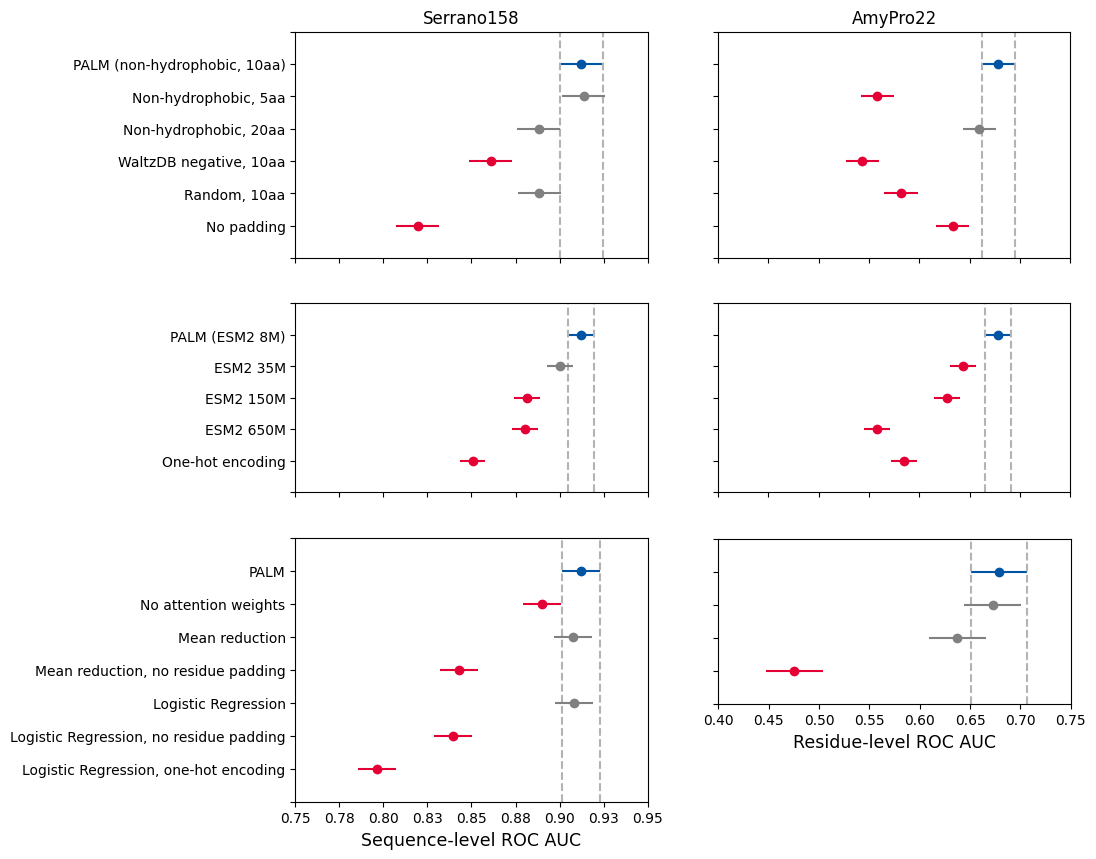

In [57]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10), gridspec_kw={'height_ratios': [6, 5, 7]})
new_plot_simultaneous(tukey_pad_amypro, comparison_name=best_pad['model'].reset_index(drop=True)[0], ax=[0,1], title='AmyPro22', xlim=[0.4,0.75])
new_plot_simultaneous(tukey_pad_serrano, comparison_name=best_pad['model'].reset_index(drop=True)[0], ax=[0,0], title='Serrano158', xlim=[0.75,0.95])
axs[0, 1].set_yticklabels([])


new_plot_simultaneous(tukey_emb_amypro, comparison_name=best_emb['model'].reset_index(drop=True)[0], ax=[1,1], xlim=[0.4,0.75])
new_plot_simultaneous(tukey_emb_serrano, comparison_name=best_emb['model'].reset_index(drop=True)[0], ax=[1,0], xlim=[0.75,0.95])
axs[1, 1].set_yticklabels([])


custom_ax = fig.add_axes([0.548, 0.208, 0.3525, 0.165])
axs[2, 1].set_visible(False)

new_plot_simultaneous(tukey_ab_amypro, comparison_name=best_ab['model'].reset_index(drop=True)[0], ax=custom_ax, xlim=[0.4,0.75])
new_plot_simultaneous(tukey_ab_serrano, comparison_name=best_ab['model'].reset_index(drop=True)[0], ax=[2,0], xlim=[0.75,0.95])
custom_ax.set_yticklabels([])

axs[0,0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[1,0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axs[2,0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

axs[1, 1].set_xticklabels([])
axs[1, 0].set_xticklabels([])
axs[0, 1].set_xticklabels([])
axs[0, 0].set_xticklabels([])

custom_ax.set_xlabel('Residue-level ROC AUC',fontsize=12.5)
axs[2,0].set_xlabel('Sequence-level ROC AUC',fontsize=12.5)

#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/tukey.png', dpi=1000, bbox_inches='tight')
#fig.savefig('/novo/projects/departments/cdd/public/users/ehec/au24/plotting_for_paper/2506_figures_final/tukey.pdf', dpi=1000, bbox_inches='tight')
plt.show()

# plot code

In [101]:
tukey2 = MultiComparison(data=amypro_ablations["amypro22 rocauc"], groups=amypro_ablations["model"], group_order=['LA + ESM + padded waltz + weighted mean reduction', 'LA + ESM + padded waltz + weighted mean reduction + NO attn conv', 'LA + ESM + padded waltz + MEAN reduction ', 'LA + ESM + PLAIN waltz + weighted mean reduction', 'LA + ONEHOT + padded waltz + weighted mean reduction', 'LA + ESM + PLAIN waltz + MEAN reduction'][::-1]).tukeyhsd()

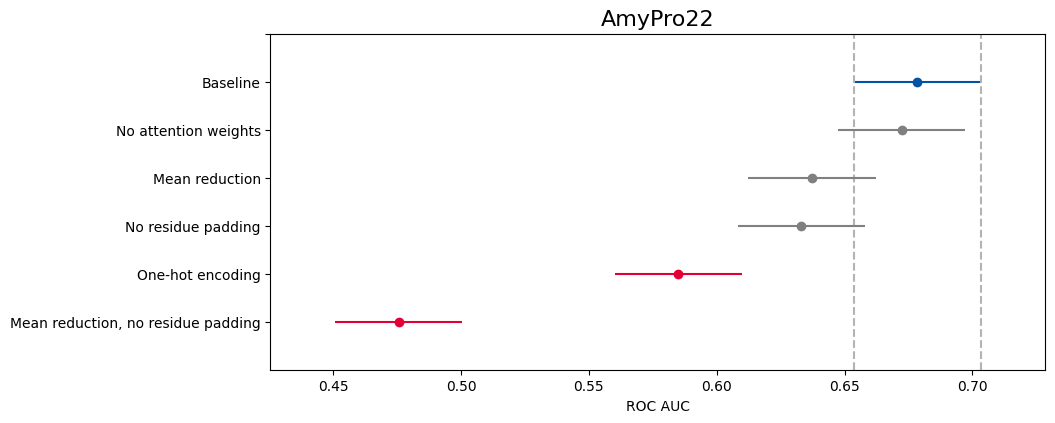

In [177]:
new_plot_simultaneous(tukey2, comparison_name=best['model'].reset_index(drop=True)[0], figsize=(10,4.3636))
plt.yticks(np.arange(7), ('Mean reduction, no residue padding', 'One-hot encoding', 'No residue padding', 'Mean reduction', 'No attention weights', 'Baseline', ''))
plt.xlabel('ROC AUC')
plt.title('AmyPro22', fontsize=16)
plt.savefig('amypro_ablations.png',  bbox_inches='tight',  dpi=600)
plt.show()

In [168]:
tukey3 = MultiComparison(data=ablations["serrano158 rocauc"], groups=ablations["model"], group_order=['LA + ESM + padded waltz + weighted mean reduction', 'LA + ESM + padded waltz + weighted mean reduction + NO attn conv', 'LA + ESM + padded waltz + MEAN reduction ', 'LA + ESM + PLAIN waltz + weighted mean reduction', 'LA + ONEHOT + padded waltz + weighted mean reduction', 'LA + ESM + PLAIN waltz + MEAN reduction', 'Logistic Regression + ESM  + padded waltz', 'Logistic Regression + ESM + PLAIN waltz','Logistic Regression + ONEHOT + padded waltz'][::-1]).tukeyhsd()

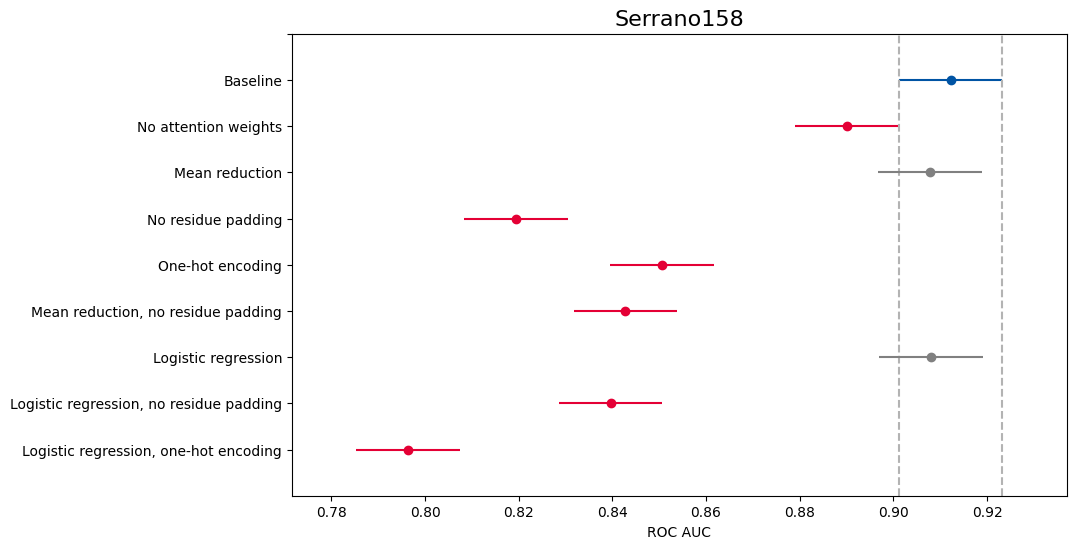

In [176]:
new_plot_simultaneous(tukey3, comparison_name=best['model'].reset_index(drop=True)[0], figsize=(10,6))
plt.yticks(np.arange(10), ('Logistic regression, one-hot encoding', 'Logistic regression, no residue padding', 'Logistic regression', 'Mean reduction, no residue padding', 'One-hot encoding', 'No residue padding', 'Mean reduction', 'No attention weights', 'Baseline', ''))
plt.title('Serrano158', fontsize=16)
plt.xlabel('ROC AUC')
plt.savefig('serrano_ablations.png', bbox_inches='tight', dpi=600)
plt.show()